# HW2P2: Face Classification and Verification


Congrats on coming to the second homework in 11785: Introduction to Deep Learning. This homework significantly longer and tougher than the previous homework. You have 2 sub-parts as outlined below. Please start early! 


*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7000 identities
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# Preliminaries

In [ ]:
!nvidia-smi # to see what GPU you have

Wed Mar 22 18:02:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install ipdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 KB 43.1 MB/s eta 0:00:00
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 2.0.10
    Uninstalling prompt-toolkit-2.0.10:
      Successfully uninstalled prompt-toolkit-2.0.10
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.11.0 which is incompatible.


In [ ]:
import torch
from torchsummary import summary
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

Mounted at /content/drive


# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data from Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!pip install --upgrade --force-reinstall --no-deps kaggle 
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"kaggle-username","key":"kaggle-key"}') 

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.13-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!mkdir '/content/data'

!kaggle competitions download -c 11-785-s23-hw2p2-classification
!unzip -qo '11-785-s23-hw2p2-classification.zip' -d '/content/data'

!kaggle competitions download -c 11-785-s23-hw2p2-verification
!unzip -qo '11-785-s23-hw2p2-verification.zip' -d '/content/data'

mkdir: cannot create directory ‘/content/data’: File exists
11-785-s23-hw2p2-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
11-785-s23-hw2p2-verification.zip: Skipping, found more recently modified local copy (use --force to force download)


# Configs

In [ ]:
config = {
    'batch_size': 128, # Increase this if your GPU can handle it
    'lr': 0.1,
    'epochs': 80, # 10 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'weight_decay'  : 1e-4,
    'label_smoothing' : 0.2,
    'T_0' : 10,
    'T_mult' : 2
}

# Classification Dataset

In [ ]:
DATA_DIR    = '/content/data/11-785-s23-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train") 
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5116, 0.4026, 0.3519),(0.3073, 0.2697, 0.2587))
])# Implementing the right train transforms/augmentation methods is key to improving performance.

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ToPILImage(), # If the input has 3 channels, the mode is assumed to be RGB
    torchvision.transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given image randomly with a given probability
    torchvision.transforms.RandomRotation(12), # Rotate the image by angle
    torchvision.transforms.RandomGrayscale(p=0.1), # Randomly convert image to grayscale with a probability of p default=0.1
    torchvision.transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2), # Randomly change the brightness, contrast, saturation and hue of an image.
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomErasing(scale=(0.1, 0.1)), # Randomly selects a rectangle region in a torch.Tensor image and erases its pixels
    torchvision.transforms.Normalize((0.5116, 0.4026, 0.3519),(0.3073, 0.2697, 0.2587))
    # torchvision.transforms.RandAugment(), # Best for convnext only
    # torchvision.transforms.RandomResizedCrop(0.1, 0.8),
])

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?
# you might overfit your model, plus validation set is representative of the test data which is not augmented

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 4, 
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset, 
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

In [ ]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [ ]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 2)

In [ ]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7000
No. of train images  :  140000
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  128
Train batches        :  1094
Val batches          :  274


## Data visualization

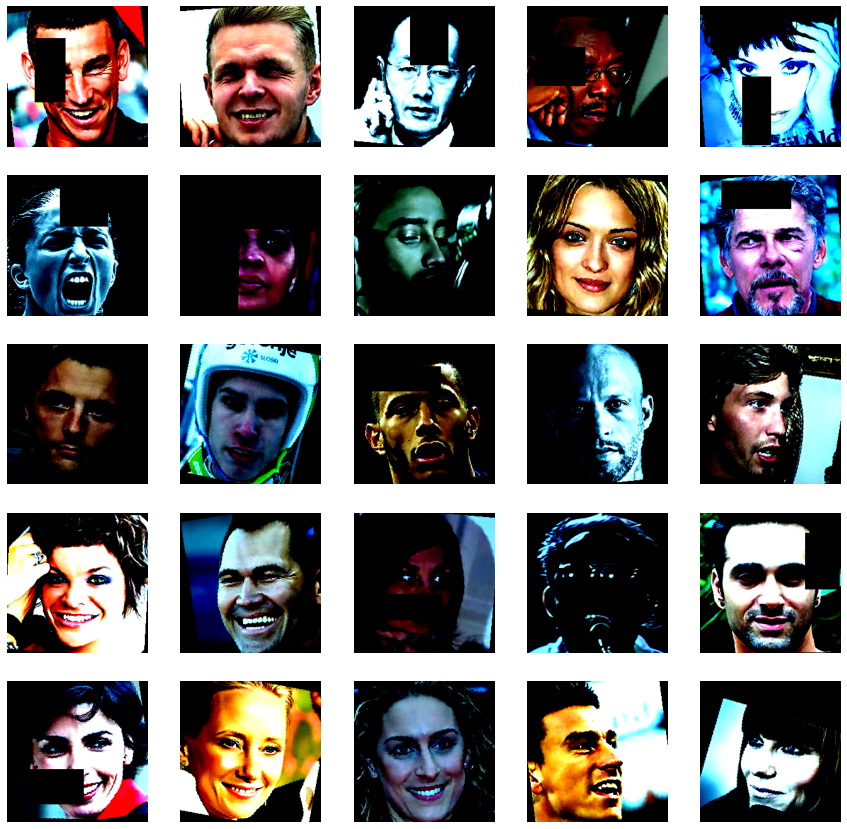

In [ ]:
# Visualize a few images in the dataset
# You can write your own code, and you don't need to understand the code
# It is highly recommended that you visualize your data augmentation as sanity check

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'], 
    shuffle     = True,
)

for data in dtl:
    x, y = data
    
    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Very Simple Network (for Mandatory Early Submission)

In [ ]:

import ipdb
class Network(torch.nn.Module):
    """
    The Very Low early deadline architecture is a 4-layer CNN.

    The first Conv layer has 64 channels, kernel size 7, and stride 4.
    The next three have 128, 256, and 512 channels. Each have kernel size 3 and stride 2.
    
    Think about strided convolutions from the lecture, as convolutioin with stride= 1 and downsampling.
    For stride 1 convolution, what padding do you need for preserving the spatial resolution? 
    (Hint => padding = kernel_size // 2) - Why?)

    Each Conv layer is accompanied by a Batchnorm and ReLU layer.
    Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d.
    Then, remove (Flatten?) these trivial 1x1 dimensions away.
    Look through https://pytorch.org/docs/stable/nn.html 
    
    TODO: Fill out the model definition below! 

    Why does a very simple network have 4 convolutions?
    Input images are 224x224. Note that each of these convolutions downsample.
    Downsampling 2x effectively doubles the receptive field, increasing the spatial
    region each pixel extracts features from. Downsampling 32x is standard
    for most image models.

    Why does a very simple network have high channel sizes?
    Every time you downsample 2x, you do 4x less computation (at same channel size).
    To maintain the same level of computation, you 2x increase # of channels, which 
    increases computation by 4x. So, balances out to same computation.
    Another intuition is - as you downsample, you lose spatial information. We want
    to preserve some of it in the channel dimension.
    """

    def __init__(self, num_classes=7000):
        super().__init__()

        self.backbone = torch.nn.Sequential(
            # first conv layer
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=4), 
            torch.nn.BatchNorm2d(64), 
            torch.nn.ReLU(),

            # second conv layer
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2), 
            torch.nn.BatchNorm2d(128), 
            torch.nn.ReLU(),

            # third conv layer
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2), 
            torch.nn.BatchNorm2d(256), 
            torch.nn.ReLU(),

            # fourth conv layer
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2), 
            torch.nn.BatchNorm2d(512), 
            torch.nn.ReLU()
        ) 
        
        self.cls_layer = torch.nn.Linear(in_features=512, out_features=num_classes)
    
    def forward(self, x, return_feats=False):
        """
        What is return_feats? It essentially returns the second-to-last-layer
        features of a given image. It's a "feature encoding" of the input image,
        and you can use it for the verification task. You would use the outputs
        of the final classification layer for the classification task.

        You might also find that the classification outputs are sometimes better
        for verification too - try both.
        """
        feats = self.backbone(x)
        # ipdb.set_trace()
        global_average_pool=torch.nn.functional.avg_pool2d(feats,feats.size()[2:])       
        global_average_pool_flatten=global_average_pool.view(global_average_pool.size(0),-1) 
        out = self.cls_layer(global_average_pool_flatten)

        if return_feats:
            return global_average_pool_flatten
        else:
            return out
            
model = Network().to(DEVICE)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]           9,472
       BatchNorm2d-2           [-1, 64, 55, 55]             128
              ReLU-3           [-1, 64, 55, 55]               0
            Conv2d-4          [-1, 128, 27, 27]          73,856
       BatchNorm2d-5          [-1, 128, 27, 27]             256
              ReLU-6          [-1, 128, 27, 27]               0
            Conv2d-7          [-1, 256, 13, 13]         295,168
       BatchNorm2d-8          [-1, 256, 13, 13]             512
              ReLU-9          [-1, 256, 13, 13]               0
           Conv2d-10            [-1, 512, 6, 6]       1,180,160
      BatchNorm2d-11            [-1, 512, 6, 6]           1,024
             ReLU-12            [-1, 512, 6, 6]               0
           Linear-13                 [-1, 7000]       3,591,000
Total params: 5,151,576
Trainable param

# ResNet-50 
[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
---
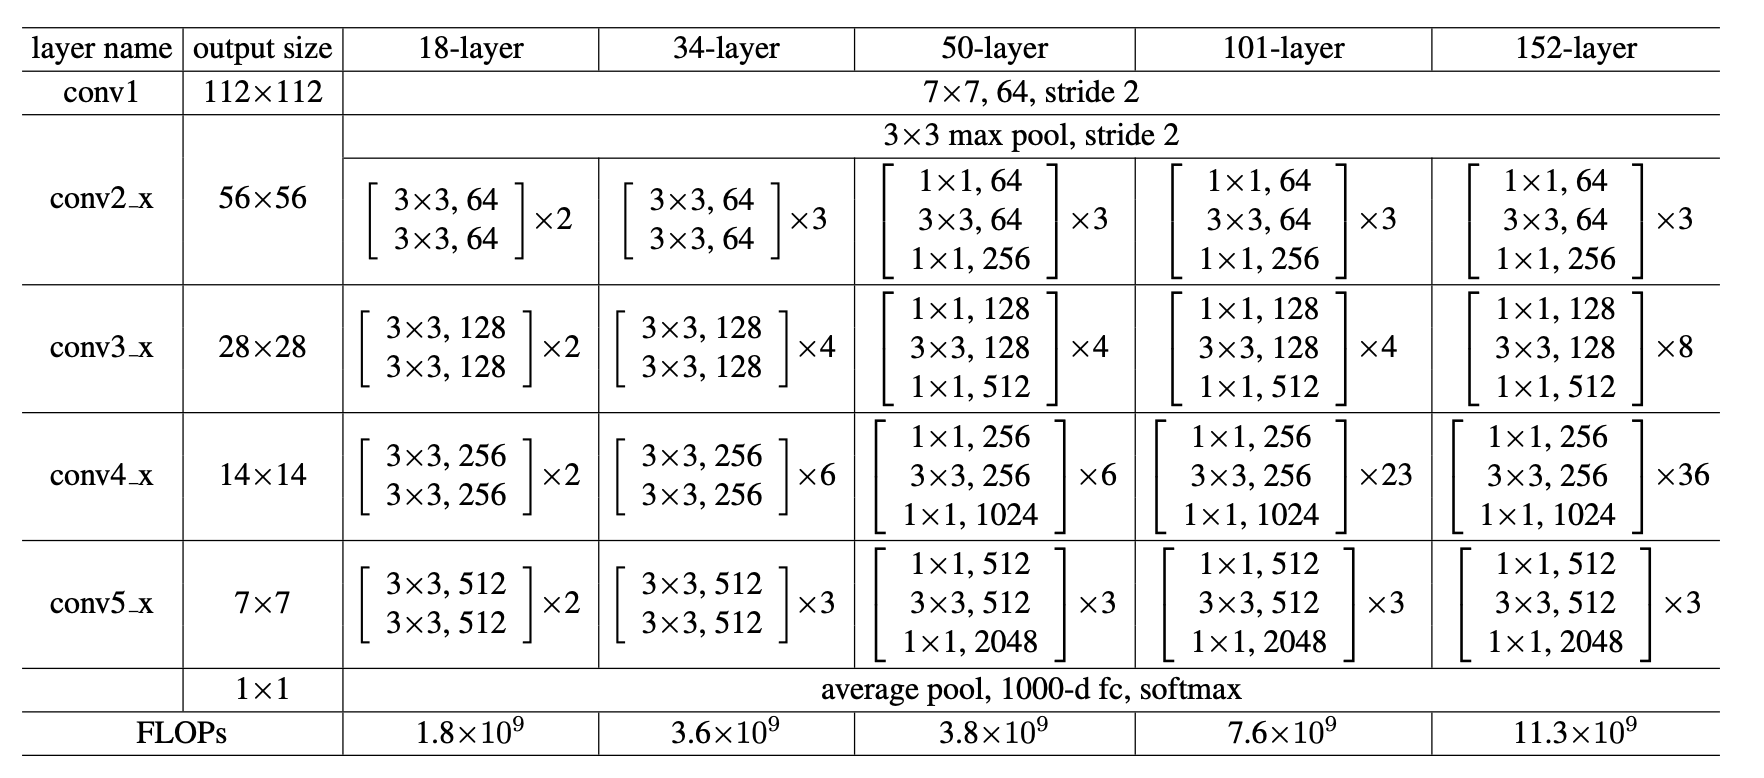



---



---



In [ ]:
import torch
import torch.nn as  nn
import torch.nn.functional as F
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, reshape_layer=None, stride=1):
        super(Bottleneck, self).__init__()
        # residual block skeleton
        self.backbone = torch.nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
            nn.BatchNorm2d(out_channels*self.expansion)
        )
        self.reshape_layer = reshape_layer
        self.stride = stride
        self.activation = nn.ReLU() 
        
    def forward(self, x):
        identity = x.clone()
        feats = self.backbone(x)
        
        #downsample if needed
        if self.reshape_layer is not None:
            identity = self.reshape_layer(identity)
        #add identity
        feats += identity
        feats=self.activation(feats)
        return feats

In [ ]:
class Block(nn.Module):
    expansion = 1
    def __init__(self, input_channels, out_channels, reshape_layer=None, stride=1):
        super(Block, self).__init__()

        # residual block skeleton
        self.backbone = torch.nn.Sequential(
            nn.Conv2d(input_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.reshape_layer = reshape_layer
        self.stride = stride
        self.activation = nn.ReLU()

    def forward(self, x):
      identity = x.clone()
      feats = self.backbone(x)

      if self.reshape_layer is not None:
          identity = self.reshape_layer(identity)
      feats += identity
      feats = self.activation(feats)
      return feats

In [ ]:
class ResNet50(nn.Module):
    """
    For ResNet-50, layers = [3, 4, 6, 3]
    image_channels = 3 (RGB)
    num_classes=7000 for our task
    """
    def __init__(self, ResidualBlock, layers, num_classes, image_channels=3):
        super().__init__()
        #64
        self.input_channels = 64

        self.backbone = torch.nn.Sequential(
            # conv1 layer (7×7, 64, stride 2) o/p width=112
            nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # conv2_x layer 
            # 3×3 max pool, stride 2
            nn.MaxPool2d(kernel_size = 3, stride=2, padding=1),
            # residual layers
            self._make_layer(ResidualBlock, layers[0], output_channels=64),
            # conv3_x layer
            self._make_layer(ResidualBlock, layers[1], output_channels=128, stride=2),
            # conv4_x layer
            self._make_layer(ResidualBlock, layers[2], output_channels=256, stride=2)
            # conv5_x layer
            self._make_layer(ResidualBlock, layers[3], output_channels=512, stride=2),
            # average pool, 1000-d fc, softmax
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.cls_layer = nn.Linear(in_features=512*4, out_featuresnum_classes)
        
    def forward(self, x):
        feats = self.backbone(x)
        feats = feats.reshape(feats.shape[0], -1)
        out = self.cls_layer(feats)
        
        return out
        
    def _make_layer(self, ResidualBlock, num_blocks, output_channels, stride=1):
        reshape_layer = None
        network_layers = []
        
        if stride != 1 or self.input_channels != output_channels*4:
            reshape_layer = nn.Sequential(
                nn.Conv2d(self.input_channels, output_channels*4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels*4)
            )
            
        network_layers.append(ResidualBlock(self.input_channels, output_channels, reshape_layer=reshape_layer, stride=stride))
        self.input_channels = output_channels**4 #256, 512, 1024
        
        for i in range(num_blocks-1):
            network_layers.append(ResidualBlock(self.input_channels, output_channels))
            
        return nn.Sequential(*network_layers)

model = ResNet50(Bottleneck, layers=[3,4,6,3], num_classes=7000, image_channels=3).to(DEVICE)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
      BatchNorm2d-14          [-1, 256,



---



---



# Setup everything for training

In [ ]:
# TODO: What loss do you need for a multi class classification problem?
criterion = torch.nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=config['weight_decay'])
# TODO: Implement a scheduler (Optional but Highly Recommended)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'], T_mult=config['T_mult'])
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

# Let's train!

In [ ]:
def train(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() 

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar
    # scheduler.step()

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="wandb-key") #API Key is in your wandb account, under settings (wandb.ai/settings)

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "resnet50-norm-cos-warmup", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/11-785-IDL/HW/HW2/checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
torch.cuda.empty_cache()

# Experiments

In [ ]:
best_valacc = 0.0

for epoch in range(config['epochs']):

    # curr_lr = float(optimizer.param_groups[0]['lr'])
    curr_lr = 0.005

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss = validate(model, valid_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    # wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
    #            'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently 
    scheduler.step()

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc, 
                  'epoch': epoch}, '/content/drive/MyDrive/11-785-IDL/HW/HW2/checkpoint.pth')
      best_valacc = val_acc
      # wandb.save('checkpoint.pth')
      # You may find it interesting to exlplore Wandb Artifcats to version your models
# run.finish()


Epoch 1/80: 
Train Acc 88.6369%	 Train Loss 3.0478	 Learning Rate 0.0050


Val Acc 72.2628%	 Val Loss 3.8203
Saving model



Epoch 2/80: 
Train Acc 86.0453%	 Train Loss 3.1391	 Learning Rate 0.0050


Val Acc 67.5981%	 Val Loss 3.9611



Epoch 3/80: 
Train Acc 89.3010%	 Train Loss 3.0278	 Learning Rate 0.0050


Val Acc 69.5084%	 Val Loss 3.9223



Epoch 4/80: 
Train Acc 93.0773%	 Train Loss 2.8996	 Learning Rate 0.0050


Val Acc 75.2081%	 Val Loss 3.7189
Saving model



Epoch 5/80: 
Train Acc 96.1273%	 Train Loss 2.7796	 Learning Rate 0.0050


Val Acc 77.2468%	 Val Loss 3.6542
Saving model



Epoch 6/80: 
Train Acc 98.0812%	 Train Loss 2.6788	 Learning Rate 0.0050


Val Acc 82.1453%	 Val Loss 3.4304
Saving model



Epoch 7/80: 
Train Acc 99.0059%	 Train Loss 2.6021	 Learning Rate 0.0050


Val Acc 84.4206%	 Val Loss 3.3555
Saving model



Epoch 8/80: 
Train Acc 99.4787%	 Train Loss 2.5481	 Learning Rate 0.0050


Val Acc 85.8577%	 Val Loss 3.2979
Saving model



Epoch 9/80: 
Train Acc 99.6636%	 Train Loss 2.5166	 Learning Rate 0.0050


Val Acc 86.5220%	 Val Loss 3.2867
Saving model



Epoch 10/80: 
Train Acc 99.7365%	 Train Loss 2.5004	 Learning Rate 0.0050


Val Acc 86.8870%	 Val Loss 3.2800
Saving model



Epoch 11/80: 
Train Acc 83.1417%	 Train Loss 3.2271	 Learning Rate 0.0050


Val Acc 64.7782%	 Val Loss 4.0696



Epoch 12/80: 
Train Acc 85.7368%	 Train Loss 3.1464	 Learning Rate 0.0050


Val Acc 66.6258%	 Val Loss 4.0359



Epoch 13/80: 
Train Acc 89.1725%	 Train Loss 3.0332	 Learning Rate 0.0050


Val Acc 71.4074%	 Val Loss 3.8353



Epoch 14/80: 
Train Acc 91.1763%	 Train Loss 2.9661	 Learning Rate 0.0050


Val Acc 69.8706%	 Val Loss 3.9286



Epoch 15/80: 
Train Acc 92.7688%	 Train Loss 2.9110	 Learning Rate 0.0050


Val Acc 73.8310%	 Val Loss 3.7760



Epoch 16/80: 
Train Acc 94.0128%	 Train Loss 2.8651	 Learning Rate 0.0050


Val Acc 74.4782%	 Val Loss 3.7360



Epoch 17/80: 
Train Acc 95.1097%	 Train Loss 2.8210	 Learning Rate 0.0050


Val Acc 76.2260%	 Val Loss 3.6851



Epoch 18/80: 
Train Acc 96.1687%	 Train Loss 2.7769	 Learning Rate 0.0050


Val Acc 78.1963%	 Val Loss 3.5970



Epoch 19/80: 
Train Acc 97.1499%	 Train Loss 2.7277	 Learning Rate 0.0050


Val Acc 78.9433%	 Val Loss 3.5863



Epoch 20/80: 
Train Acc 97.9612%	 Train Loss 2.6834	 Learning Rate 0.0050


Val Acc 81.9058%	 Val Loss 3.4552



Epoch 21/80: 
Train Acc 98.5775%	 Train Loss 2.6373	 Learning Rate 0.0050


Val Acc 83.3771%	 Val Loss 3.4022



Epoch 22/80: 
Train Acc 99.0338%	 Train Loss 2.6004	 Learning Rate 0.0050


Val Acc 83.6508%	 Val Loss 3.4118



Epoch 23/80: 
Train Acc 99.3601%	 Train Loss 2.5634	 Learning Rate 0.0050


Val Acc 85.2988%	 Val Loss 3.3414



Epoch 24/80: 
Train Acc 99.5515%	 Train Loss 2.5338	 Learning Rate 0.0050


Val Acc 86.3794%	 Val Loss 3.2825



Epoch 25/80: 
Train Acc 99.6901%	 Train Loss 2.5093	 Learning Rate 0.0050


Val Acc 86.8784%	 Val Loss 3.2661



Epoch 26/80: 
Train Acc 99.7686%	 Train Loss 2.4900	 Learning Rate 0.0050


Val Acc 87.3574%	 Val Loss 3.2582
Saving model



Epoch 27/80: 
Train Acc 99.8122%	 Train Loss 2.4756	 Learning Rate 0.0050


Val Acc 87.7195%	 Val Loss 3.2414
Saving model



Epoch 28/80: 
Train Acc 99.8515%	 Train Loss 2.4649	 Learning Rate 0.0050


Val Acc 87.9534%	 Val Loss 3.2325
Saving model



Epoch 29/80: 
Train Acc 99.8793%	 Train Loss 2.4589	 Learning Rate 0.0050


Val Acc 88.0503%	 Val Loss 3.2276
Saving model



Epoch 30/80: 
Train Acc 99.8829%	 Train Loss 2.4560	 Learning Rate 0.0050


Val Acc 88.1358%	 Val Loss 3.2311
Saving model



Epoch 31/80: 
Train Acc 76.2868%	 Train Loss 3.4560	 Learning Rate 0.0050


Val Acc 59.9110%	 Val Loss 4.2532



Epoch 32/80: 
Train Acc 85.4069%	 Train Loss 3.1580	 Learning Rate 0.0050


Val Acc 68.0058%	 Val Loss 3.9821



Epoch 33/80: 
Train Acc 89.3689%	 Train Loss 3.0259	 Learning Rate 0.0050


Val Acc 72.2000%	 Val Loss 3.8178



Epoch 34/80: 
Train Acc 91.3620%	 Train Loss 2.9603	 Learning Rate 0.0050


Val Acc 72.3882%	 Val Loss 3.8184



Epoch 35/80: 
Train Acc 92.1397%	 Train Loss 2.9295	 Learning Rate 0.0050


Val Acc 71.8807%	 Val Loss 3.8541



Epoch 36/80: 
Train Acc 92.8416%	 Train Loss 2.9077	 Learning Rate 0.0050


Val Acc 72.3597%	 Val Loss 3.8045



Epoch 37/80: 
Train Acc 93.0809%	 Train Loss 2.8961	 Learning Rate 0.0050


Val Acc 72.8416%	 Val Loss 3.8317



Epoch 38/80: 
Train Acc 93.6157%	 Train Loss 2.8801	 Learning Rate 0.0050


Val Acc 72.9385%	 Val Loss 3.8325



Epoch 39/80: 
Train Acc 94.0492%	 Train Loss 2.8647	 Learning Rate 0.0050


Val Acc 73.8367%	 Val Loss 3.7640



Epoch 40/80: 
Train Acc 94.4177%	 Train Loss 2.8480	 Learning Rate 0.0050


Val Acc 75.2310%	 Val Loss 3.7334



Epoch 41/80: 
Train Acc 94.9954%	 Train Loss 2.8261	 Learning Rate 0.0050


Val Acc 76.8818%	 Val Loss 3.6752



Epoch 42/80: 
Train Acc 95.4011%	 Train Loss 2.8075	 Learning Rate 0.0050


Val Acc 75.9466%	 Val Loss 3.6949



Epoch 43/80: 
Train Acc 95.7174%	 Train Loss 2.7938	 Learning Rate 0.0050


Val Acc 77.3694%	 Val Loss 3.6501



Epoch 44/80: 
Train Acc 96.1823%	 Train Loss 2.7737	 Learning Rate 0.0050


Val Acc 77.3951%	 Val Loss 3.6606



Epoch 45/80: 
Train Acc 96.6422%	 Train Loss 2.7519	 Learning Rate 0.0050


Val Acc 78.9946%	 Val Loss 3.5998



Epoch 46/80: 
Train Acc 96.9378%	 Train Loss 2.7343	 Learning Rate 0.0050


Val Acc 79.4480%	 Val Loss 3.5602



Epoch 47/80: 
Train Acc 97.4027%	 Train Loss 2.7120	 Learning Rate 0.0050


Val Acc 81.3042%	 Val Loss 3.4991



Epoch 48/80: 
Train Acc 97.7955%	 Train Loss 2.6898	 Learning Rate 0.0050


Val Acc 79.3653%	 Val Loss 3.5945



Epoch 49/80: 
Train Acc 98.1683%	 Train Loss 2.6688	 Learning Rate 0.0050


Val Acc 82.0826%	 Val Loss 3.4710



Epoch 50/80: 
Train Acc 98.3718%	 Train Loss 2.6519	 Learning Rate 0.0050


Val Acc 81.0190%	 Val Loss 3.5361



Epoch 51/80: 
Train Acc 98.5825%	 Train Loss 2.6329	 Learning Rate 0.0050


Val Acc 83.0663%	 Val Loss 3.4136



Epoch 52/80: 
Train Acc 98.9124%	 Train Loss 2.6108	 Learning Rate 0.0050


Val Acc 82.6927%	 Val Loss 3.4488



Epoch 53/80: 
Train Acc 99.1095%	 Train Loss 2.5886	 Learning Rate 0.0050


Val Acc 84.8483%	 Val Loss 3.3523



Epoch 54/80: 
Train Acc 99.2766%	 Train Loss 2.5690	 Learning Rate 0.0050


Val Acc 85.0251%	 Val Loss 3.3582



Epoch 55/80: 
Train Acc 99.4466%	 Train Loss 2.5507	 Learning Rate 0.0050


Val Acc 85.5269%	 Val Loss 3.3417



Epoch 56/80: 
Train Acc 99.5322%	 Train Loss 2.5322	 Learning Rate 0.0050


Val Acc 86.7159%	 Val Loss 3.2940



Epoch 57/80: 
Train Acc 99.6472%	 Train Loss 2.5170	 Learning Rate 0.0050


Val Acc 87.1037%	 Val Loss 3.2607



Epoch 58/80: 
Train Acc 99.7015%	 Train Loss 2.5014	 Learning Rate 0.0050


Val Acc 87.4800%	 Val Loss 3.2422



Epoch 59/80: 
Train Acc 99.7708%	 Train Loss 2.4873	 Learning Rate 0.0050


Val Acc 87.7566%	 Val Loss 3.2400



Epoch 60/80: 
Train Acc 99.8115%	 Train Loss 2.4752	 Learning Rate 0.0050


Val Acc 88.1758%	 Val Loss 3.2204
Saving model



Epoch 61/80: 
Train Acc 99.8472%	 Train Loss 2.4641	 Learning Rate 0.0050


Val Acc 88.4096%	 Val Loss 3.2116
Saving model



Epoch 62/80: 
Train Acc 99.8593%	 Train Loss 2.4550	 Learning Rate 0.0050


Val Acc 88.6120%	 Val Loss 3.1960
Saving model



Epoch 63/80: 
Train Acc 99.8893%	 Train Loss 2.4469	 Learning Rate 0.0050


Val Acc 88.9057%	 Val Loss 3.1864
Saving model



Epoch 64/80: 
Train Acc 99.9064%	 Train Loss 2.4408	 Learning Rate 0.0050


Val Acc 89.0169%	 Val Loss 3.1869
Saving model



Epoch 65/80: 
Train Acc 99.9100%	 Train Loss 2.4359	 Learning Rate 0.0050


Val Acc 89.0939%	 Val Loss 3.1829
Saving model



Epoch 66/80: 
Train Acc 99.9057%	 Train Loss 2.4315	 Learning Rate 0.0050


Val Acc 89.1994%	 Val Loss 3.1805
Saving model



Epoch 67/80: 
Train Acc 99.9279%	 Train Loss 2.4276	 Learning Rate 0.0050


Val Acc 89.3875%	 Val Loss 3.1785
Saving model


Train:  13%|█▎        | 145/1094 [01:21<08:46,  1.80it/s, acc=99.9625%, loss=2.4252, lr=0.0014, num_correct=18681]

In [ ]:
run.finish()

# Classification Task: Testing

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  
  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)
      
      batch_bar.update()
      
  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)


## Generate csv to submit to Kaggle

In [ ]:
with open("classification_late_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(5) + ".jpg", test_results[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-classification-slackkaggle -f classification_late_submission.csv -m "late submission"

100% 507k/507k [00:03<00:00, 152kB/s]
Successfully submitted to Face Classification (Slack)

## On-time Submission


---




In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-classification -f classification_early_submission.csv -m "early submission"

100% 507k/507k [00:02<00:00, 211kB/s]
Successfully submitted to Face Classification

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites 
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities. 

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s23-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done
print(unknown_dev_images.shape)
print(unknown_test_images.shape)
print(known_images.shape)


# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6) 

100%|██████████| 960/960 [00:00<00:00, 14775.50it/s]


torch.Size([360, 3, 224, 224])
torch.Size([720, 3, 224, 224])
torch.Size([960, 3, 224, 224])


In [ ]:
import ipdb
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'): 

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size
        
        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE)) #Get features from model         
        unknown_feats.append(unknown_feat)
        batch_bar.update()
    
    batch_bar.close()
    
    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    
    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size] 
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE))
          
        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain 
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    # ipdb.set_trace()
    # pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings
    
    # After early submission, remove the previous line and uncomment the following code 

    threshold = 0.05# Choose a proper threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])
    
    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s23-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
    
    return pred_id_strings

In [ ]:
# verification eval
pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
# verification test
pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

Verification Accuracy = 0.4444444444444444


In [ ]:
      # add your finetune/retrain code here

In [ ]:
print(len(pred_id_strings))

## Generate csv to submit to Kaggle

In [ ]:
with open("verification_late_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))



In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-verification-slack -f verification_late_submission.csv -m "late submission"

100% 8.34k/8.34k [00:02<00:00, 4.02kB/s]
Successfully submitted to Face Verification (Slack)